<a href="https://colab.research.google.com/github/AndrewEPrince/codespaces-blank/blob/main/models/ballsnet/BallsNetTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installs
!pip install tensorflow --upgrade
!pip install tensorflow-gpu --upgrade
!pip install keras --upgrade

In [ ]:
#@title Imports
%load_ext tensorboard
import tensorboard

from datetime import datetime
from packaging import version
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import joblib
from google.colab import files


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Masking, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD, RMSprop, AdamW, Adadelta, Adagrad, Adamax, Nadam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import Accuracy, Precision, Recall, F1Score, AUC, CategoricalAccuracy, SparseCategoricalAccuracy
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler, EarlyStopping, Callback, ReduceLROnPlateau
from keras.regularizers import l2, L1L2, L2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.15.0


In [ ]:
#@title Get Season Data
season_urls = {
    "season_17_urls" : {
    "https://ballchasing.com/api/groups/1premier-fljs2rxwse/" : 1,
    "https://ballchasing.com/api/groups/2master-er4ijj6bzr/" : 2,
    "https://ballchasing.com/api/groups/3elite-s8z53z7uh5/" : 3,
    "https://ballchasing.com/api/groups/4veteran-02ujkewot4/" : 4,
    "https://ballchasing.com/api/groups/5rival-mrp8b1bamo/" : 5,
    "https://ballchasing.com/api/groups/6challenger-a3a3j0nkec/" : 6,
    "https://ballchasing.com/api/groups/7prospect-jt1f5epq9r/" : 7,
    "https://ballchasing.com/api/groups/8contender-9n998x8mm8/" : 8,
    "https://ballchasing.com/api/groups/9amateur-wmq7szund6/" : 9
    }
    ,
    "season_18_urls" : {
    "https://ballchasing.com/api/groups/1premier-0bltbgd7ox/" : 1,
    "https://ballchasing.com/api/groups/2master-oe6pooca8v/" : 2,
    "https://ballchasing.com/api/groups/3elite-n4j3g5puuo/" : 3,
    "https://ballchasing.com/api/groups/4veteran-ntqifly5e6/" : 4,
    "https://ballchasing.com/api/groups/5rival-07eg1qhi9a/" : 5,
    "https://ballchasing.com/api/groups/6challenger-57i0g8cxr5/" : 6,
    "https://ballchasing.com/api/groups/7prospect-qyyo3i7lvm/" : 7,
    "https://ballchasing.com/api/groups/8contender-gjm3xw4bb5/" : 8,
    "https://ballchasing.com/api/groups/9amateur-zmcevpgmnn/" : 9
  }
}

headers = {'Authorization': '8wjl1G9d8V8Ymfju7hH8K57aKNUiNhYe5oOYOxNr'}

for s, season in enumerate(season_urls.keys()):
  for u, url in enumerate(season_urls[season].keys()):
    response = requests.get(url, headers=headers)
    data = json.loads(response.text)
    temp_df = pd.json_normalize(data)
    temp_df['rank'] = season_urls[season][url]
    df = temp_df if s == 0 and u == 0 else pd.concat([df, temp_df])

# display(df)

In [ ]:
#@title Extract Player Data
for i in range(len(df)):
  rank_df = pd.DataFrame(pd.json_normalize(df.iloc[i]['players']))
  for j in range(len(rank_df)):
    temp_df = pd.DataFrame(rank_df.iloc[j]).T
    temp_df['rank'] = df.iloc[i]['rank']
    player_df = temp_df if i == 0 and j == 0 else pd.concat([player_df, temp_df])

display(player_df)

,platform,id,name,team,cumulative.games,cumulative.wins,cumulative.win_percentage,cumulative.play_duration,cumulative.core.shots,cumulative.core.shots_against,...,game_average.positioning.percent_defensive_third,game_average.positioning.percent_offensive_third,game_average.positioning.percent_neutral_third,game_average.positioning.percent_defensive_half,game_average.positioning.percent_offensive_half,game_average.positioning.percent_behind_ball,game_average.positioning.percent_infront_ball,game_average.demo.inflicted,game_average.demo.taken,rank
0,Steam,76561198968803489,.Andy,HURRICANES,52,28,53.846153,18599,163,435,...,49.01793,20.097721,30.884348,65.05415,34.945843,72.205505,27.794495,0.846154,1.076923,1
1,Steam,76561198174404581,ASHES.,HURRICANES,54,24,44.444443,20318,132,458,...,46.23599,22.74716,31.016848,62.92222,37.077785,69.55603,30.443964,1.444444,1.074074,1
2,Steam,76561198065191659,Almost Magic Mike,HURRICANES,36,14,38.88889,12751,81,299,...,47.43638,21.085146,31.47848,64.156166,35.84383,71.22679,28.773212,1.944444,1.25,1
3,Steam,76561198183908069,Angebro,HURRICANES,37,15,40.54054,13912,101,289,...,45.235226,21.447758,33.317013,62.104992,37.89501,70.86109,29.138906,0.675676,0.891892,1
4,Epic,766976eafb6a412d9327382ad43e4fb6,Anges Dad,HURRICANES,4,4,100.0,1367,12,27,...,47.895966,19.881123,32.22291,65.688576,34.31142,75.70233,24.29767,0.75,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,PS4,jdoyle15,jdoyle15,HOUSE SALADS,11,6,54.545456,3871,9,76,...,58.638527,16.573832,24.787643,72.55447,27.44554,72.22322,27.776785,1.0,0.636364,9
55,Epic,a0260508a58545a285792aca8a0188c0,llToxic_Dripll,SKETCH SQUAD,32,12,37.5,12147,69,237,...,50.090034,21.179878,28.730082,65.502304,34.497692,69.2537,30.7463,0.46875,0.46875,9
56,Steam,76561198120315116,lostperson,PRAETORIANS,52,20,38.46154,18760,99,390,...,52.532864,17.898989,29.568146,68.87725,31.122753,73.60178,26.398214,0.826923,0.711538,9
57,Steam,76561198148415662,ous,ALFREDO ARMY,47,19,40.425533,16958,89,309,...,51.387386,18.737587,29.875029,67.51461,32.485394,72.28132,27.71868,1.0,0.914894,9


In [ ]:
#@title Initialize Data for Training
temp_player_df = player_df.drop(columns=['platform'], axis=1)
temp_player_df = temp_player_df.drop(columns=['id'], axis=1)
temp_player_df = temp_player_df.drop(columns=['name'], axis=1)
temp_player_df = temp_player_df.drop(columns=['team'], axis=1)

sorted_columns = ['cumulative.core.mvp', 'game_average.core.mvp', 'cumulative.positioning.time_offensive_half',
                  'cumulative.games', 'cumulative.boost.count_stolen_big',
                  'cumulative.boost.count_collected_big', 'cumulative.positioning.time_offensive_third',
                  'cumulative.core.score', 'cumulative.positioning.time_behind_ball',
                  'cumulative.positioning.time_most_back', 'cumulative.boost.amount_stolen',
                  'cumulative.core.shots', 'cumulative.wins',
                  'cumulative.positioning.time_infront_ball', 'cumulative.positioning.time_neutral_third',
                  'cumulative.movement.time_supersonic_speed', 'cumulative.boost.amount_stolen_small',
                  'cumulative.movement.time_boost_speed', 'cumulative.core.assists',
                  'cumulative.movement.time_ground', 'cumulative.play_duration',
                  'cumulative.boost.time_boost_50_75', 'cumulative.positioning.time_closest_to_ball',
                  'cumulative.boost.amount_stolen_big', 'cumulative.positioning.time_defensive_third',
                  'cumulative.positioning.goals_against_while_last_defender', 'cumulative.movement.total_distance',
                  'cumulative.boost.count_stolen_small', 'cumulative.boost.amount_collected_small',
                  'cumulative.positioning.time_defensive_half', 'cumulative.boost.amount_collected_big',
                  'cumulative.boost.amount_overfill', 'cumulative.movement.avg_powerslide_duration',
                  'cumulative.core.goals', 'cumulative.boost.count_collected_small',
                  'cumulative.movement.time_low_air', 'cumulative.core.shots_against',
                  'cumulative.positioning.time_most_forward', 'cumulative.boost.time_boost_0_25',
                  'cumulative.boost.time_boost_25_50', 'cumulative.positioning.percent_offensive_third',
                  'cumulative.movement.count_powerslide', 'cumulative.boost.amount_overfill_stolen',
                  'cumulative.positioning.time_farthest_from_ball', 'game_average.positioning.percent_infront_ball',
                  'cumulative.boost.amount_collected', 'cumulative.boost.time_boost_75_100',
                  'game_average.positioning.percent_offensive_half', 'cumulative.movement.time_slow_speed',
                  'cumulative.positioning.percent_defensive_third', 'game_average.boost.time_full_boost',
                  'cumulative.positioning.percent_infront_ball', 'cumulative.movement.time_powerslide',
                  'game_average.positioning.percent_defensive_half', 'cumulative.core.saves',
                  'cumulative.boost.time_full_boost', 'cumulative.demo.inflicted',
                  'cumulative.core.goals_against', 'game_average.positioning.percent_behind_ball',
                  'cumulative.boost.percent_boost_75_100', 'game_average.boost.percent_boost_0_25',
                  'game_average.positioning.time_infront_ball', 'cumulative.positioning.percent_behind_ball',
                  'game_average.boost.bpm', 'game_average.boost.count_stolen_big',
                  'cumulative.movement.percent_slow_speed', 'game_average.boost.time_boost_0_25',
                  'game_average.movement.percent_slow_speed', 'cumulative.boost.percent_boost_50_75',
                  'cumulative.positioning.percent_offensive_half', 'cumulative.positioning.percent_defensive_half',
                  'game_average.boost.amount_overfill_stolen', 'game_average.positioning.time_offensive_third',
                  'cumulative.boost.amount_used_while_supersonic', 'game_average.positioning.time_behind_ball',
                  'cumulative.boost.time_zero_boost', 'game_average.positioning.time_defensive_half',
                  'game_average.positioning.percent_defensive_third', 'game_average.positioning.time_offensive_half',
                  'cumulative.win_percentage', 'cumulative.boost.percent_zero_boost',
                  'cumulative.boost.percent_boost_0_25', 'game_average.core.goals',
                  'game_average.boost.bcpm', 'game_average.core.assists',
                  'game_average.boost.percent_zero_boost', 'game_average.boost.percent_boost_75_100',
                  'cumulative.boost.avg_amount', 'cumulative.demo.taken',
                  'game_average.movement.time_slow_speed', 'game_average.boost.percent_full_boost',
                  'game_average.boost.count_collected_big', 'game_average.boost.amount_overfill',
                  'game_average.boost.time_boost_50_75', 'game_average.boost.time_zero_boost',
                  'game_average.positioning.time_most_forward', 'game_average.positioning.time_defensive_third',
                  'game_average.boost.avg_amount', 'game_average.positioning.percent_offensive_third',
                  'game_average.movement.time_boost_speed', 'game_average.boost.amount_stolen_big',
                  'game_average.core.goals_against', 'cumulative.boost.bcpm',
                  'game_average.movement.total_distance', 'game_average.boost.time_boost_75_100',
                  'game_average.boost.percent_boost_50_75', 'game_average.demo.inflicted',
                  'cumulative.movement.percent_supersonic_speed', 'game_average.movement.time_low_air',
                  'cumulative.boost.percent_full_boost', 'cumulative.positioning.avg_distance_to_ball_possession',
                  'cumulative.movement.time_high_air', 'game_average.movement.time_powerslide',
                  'game_average.positioning.time_most_back', 'game_average.core.score',
                  'cumulative.movement.percent_low_air', 'game_average.boost.amount_used_while_supersonic',
                  'cumulative.movement.percent_boost_speed', 'game_average.movement.avg_speed_percentage',
                  'game_average.core.shooting_percentage', 'game_average.movement.time_supersonic_speed',
                  'game_average.boost.amount_collected_big', 'game_average.boost.amount_stolen',
                  'game_average.positioning.goals_against_while_last_defender', 'game_average.positioning.percent_neutral_third',
                  'cumulative.boost.bpm', 'game_average.boost.amount_collected', 'cumulative.positioning.avg_distance_to_ball',
                  'game_average.positioning.avg_distance_to_ball_possession', 'game_average.positioning.time_neutral_third',
                  'game_average.boost.time_boost_25_50', 'game_average.boost.percent_boost_25_50',
                  'game_average.movement.percent_boost_speed', 'game_average.core.shots',
                  'cumulative.positioning.avg_distance_to_ball_no_possession', 'game_average.movement.avg_powerslide_duration',
                  'game_average.movement.count_powerslide', 'cumulative.boost.percent_boost_25_50',
                  'game_average.positioning.time_farthest_from_ball', 'game_average.positioning.avg_distance_to_ball_no_possession',
                  'game_average.movement.time_ground', 'game_average.boost.amount_collected_small',
                  'game_average.boost.amount_stolen_small', 'game_average.boost.count_stolen_small',
                  'game_average.movement.percent_supersonic_speed', 'cumulative.core.shooting_percentage',
                  'game_average.movement.percent_low_air', 'cumulative.movement.avg_speed_percentage',
                  'game_average.positioning.time_closest_to_ball', 'game_average.boost.count_collected_small',
                  'game_average.movement.avg_speed', 'game_average.positioning.avg_distance_to_ball',
                  'cumulative.movement.avg_speed', 'cumulative.positioning.percent_neutral_third',
                  'game_average.demo.taken', 'game_average.core.saves',
                  'game_average.movement.percent_ground', 'cumulative.movement.percent_ground',
                  'game_average.core.shots_against', 'game_average.movement.percent_high_air',
                  'cumulative.movement.percent_high_air', 'game_average.movement.time_high_air']
"""
bottom_percent_to_remove = 20
columns_to_remove = sorted_columns[:round(len(sorted_columns)/20)]
print(f"Removing: {list(columns_to_remove)}")
temp_player_df = temp_player_df.drop(columns=columns_to_remove)
"""
temp_player_df = temp_player_df.drop(columns=['cumulative.games'], axis=1)
# temp_player_df = temp_player_df.filter(like='percent')
# X = np.asarray(temp_player_df)
X = np.asarray(temp_player_df.drop(columns=['rank'], axis=1))
y = np.asarray(player_df['rank'])

temp_player_df.head()
print(X.shape)
print(X[0][-1])

(2027, 161)
1.0769231


In [ ]:
# Step 1: Split the data into training and testing sets
print(y)
y_minus_one = np.asarray([val - 1 for val in y])
print(y_minus_one)
X_train, X_test, y_train, y_test = train_test_split(X, y_minus_one, test_size=0.2, random_state=42)

# Step 2: Normalize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler using joblib
joblib.dump(scaler, "ballsnet_scaler.joblib")

y_train = y_train.astype('int8')
y_test = y_test.astype('int8')

# Ensure labels are starting from 0 and encoded correctly
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_encoded = y_train_encoded.reshape(-1,)

y_test_encoded = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

print(X_train_scaled.shape, X_test_scaled.shape, y_train_categorical.shape)


[1 1 1 ... 9 9 9]
[0 0 0 ... 8 8 8]
(1621, 154) (406, 154) (1621, 9)


In [ ]:
input_dim = X_train_scaled.shape[1]

model = Sequential()
model.add(Dense(512, activation='relu', kernel_regularizer=L2(0.001), input_dim=input_dim))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_regularizer=L2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_regularizer=L2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=L2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=L2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(16, activation='relu', kernel_regularizer=L2(0.001)))
model.add(Dense(9, activation='softmax'))


model.summary()

optimizer = optimizer = AdamW(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[CategoricalAccuracy()])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

callbacks = [early_stopping, reduce_lr]



history = model.fit(
    X_train_scaled.astype('float32'),
    y_train_categorical,
    epochs=100,
    batch_size=16,
    verbose=1,
    shuffle=True,
    callbacks=callbacks,
    validation_data=(X_test_scaled.astype('float32'), y_test_categorical)
)

loss, categorical_accuracy = model.evaluate(X_test_scaled.astype('float32'), y_test_categorical)
print(f"Test Accuracy: {categorical_accuracy * 100}")


# model.save("ballsnet1.2_optimized.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ dense_789 (Dense)                  │ (None, 512)                   │      79,360 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_300            │ (None, 512)                   │       2,048 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_273 (Dropout)              │ (None, 512)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_790 (Dense)                  │ (None, 256)                   │     131,328 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_301            │ (None, 256)                   │       1,024 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_274 (Dropout)              │ (None, 256)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_791 (Dense)                  │ (None, 128)                   │      32,896 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_302            │ (None, 128)                   │         512 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_275 (Dropout)              │ (None, 128)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_792 (Dense)                  │ (None, 64)                    │       8,256 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_303            │ (None, 64)                    │         256 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_276 (Dropout)              │ (None, 64)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_793 (Dense)                  │ (None, 32)                    │       2,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_304            │ (None, 32)                    │         128 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_277 (Dropout)              │ (None, 32)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_794 (Dense)                  │ (None, 16)                    │         528 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_795 (Dense)                  │ (None, 9)                     │         153 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 258,569 (1010.04 KB)

 Trainable params: 256,585 (1002.29 KB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - categorical_accuracy: 0.1238 - loss: 3.6711 - val_categorical_accuracy: 0.2291 - val_loss: 3.1389 - learning_rate: 0.0050
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - categorical_accuracy: 0.2087 - loss: 3.1551 - val_categorical_accuracy: 0.2611 - val_loss: 2.8788 - learning_rate: 0.0050
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - categorical_accuracy: 0.2182 - loss: 2.8806 - val_categorical_accuracy: 0.3374 - val_loss: 2.5621 - learning_rate: 0.0050
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - categorical_accuracy: 0.2610 - loss: 2.6407 - val_categorical_accuracy: 0.3670 - val_loss: 2.3120 - learning_rate: 0.0050
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - categorical_accuracy: 0.2934 - loss: 2.4746 - val_categorical_accuracy: 0.3571 - val_loss: 2.1902 - learning_rate: 0.0050
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - categorical_accuracy: 0.2835 - loss: 2.3653 - val_categoric

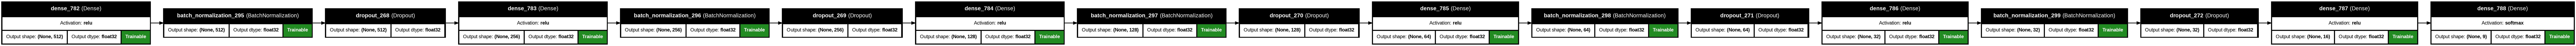

In [ ]:
keras.utils.plot_model(
    model,
    to_file="ballsnet.png",
    show_shapes=True,
        show_dtype=True,
        show_layer_names=True,
        rankdir='LR',
        expand_nested=True,
        # dpi=dpi,
        show_layer_activations=True,
        show_trainable=True,
)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


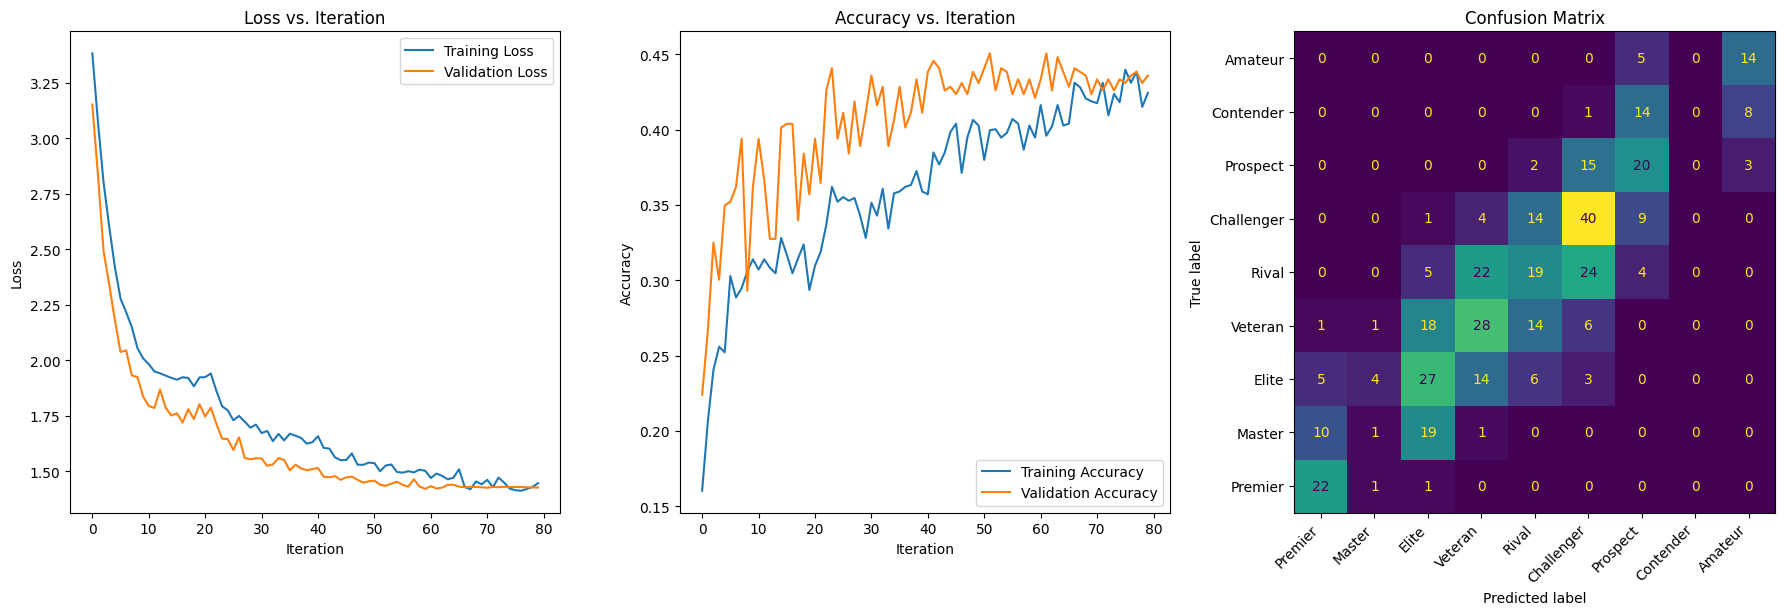

In [ ]:
#@title Plotting
classes = [
    "Premier",
    "Master",
    "Elite",
    "Veteran",
    "Rival",
    "Challenger",
    "Prospect",
    "Contender",
    "Amateur"
]

# Create a single row with three subplots
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

# Plot training loss
ax0 = plt.subplot(gs[0])
ax0.plot(history.history['loss'], label='Training Loss')
ax0.plot(history.history['val_loss'], label='Validation Loss')
ax0.set_title('Loss vs. Iteration')
ax0.set_xlabel('Iteration')
ax0.set_ylabel('Loss')
ax0.legend()

# Plot training accuracy
ax1 = plt.subplot(gs[1])
ax1.plot(history.history['categorical_accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy vs. Iteration')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Predict the classes on the test set
y_pred = np.argmax(model.predict(X_test_scaled.astype('float16')), axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix without color bar
ax2 = plt.subplot(gs[2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='viridis', values_format=".4g", ax=ax2, colorbar=False)
ax2.set_title('Confusion Matrix')

# Rotate the bottom labels by 45 degrees
plt.xticks(rotation=45, ha='right')

# Flip the x-axis
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create the Random Forest model
rf_model = RandomForestClassifier(criterion='gini', random_state=42)

# Perform Randomized Search Cross Validation
search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, cv=5, scoring='accuracy')
search.fit(X_train_scaled, y_train_categorical)

# Get the best model from the search
best_rf_model = search.best_estimator_

# Evaluate the best model on the test set
accuracy = best_rf_model.score(X_test_scaled, y_test_categorical)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Use permutation_importance to analyze feature importance
result = permutation_importance(best_rf_model, X_test_scaled, y_test_categorical, n_repeats=10, random_state=42)

Test Accuracy: 2.46%


AttributeError: ignored

['cumulative.core.mvp', 'game_average.core.mvp', 'cumulative.positioning.time_offensive_half', 'cumulative.games', 'cumulative.boost.count_stolen_big', 'cumulative.boost.count_collected_big', 'cumulative.positioning.time_offensive_third', 'cumulative.core.score', 'cumulative.positioning.time_behind_ball', 'cumulative.positioning.time_most_back', 'cumulative.boost.amount_stolen', 'cumulative.core.shots', 'cumulative.wins', 'cumulative.positioning.time_infront_ball', 'cumulative.positioning.time_neutral_third', 'cumulative.movement.time_supersonic_speed', 'cumulative.boost.amount_stolen_small', 'cumulative.movement.time_boost_speed', 'cumulative.core.assists', 'cumulative.movement.time_ground', 'cumulative.play_duration', 'cumulative.boost.time_boost_50_75', 'cumulative.positioning.time_closest_to_ball', 'cumulative.boost.amount_stolen_big', 'cumulative.positioning.time_defensive_third', 'cumulative.positioning.goals_against_while_last_defender', 'cumulative.movement.total_distance', 'cu

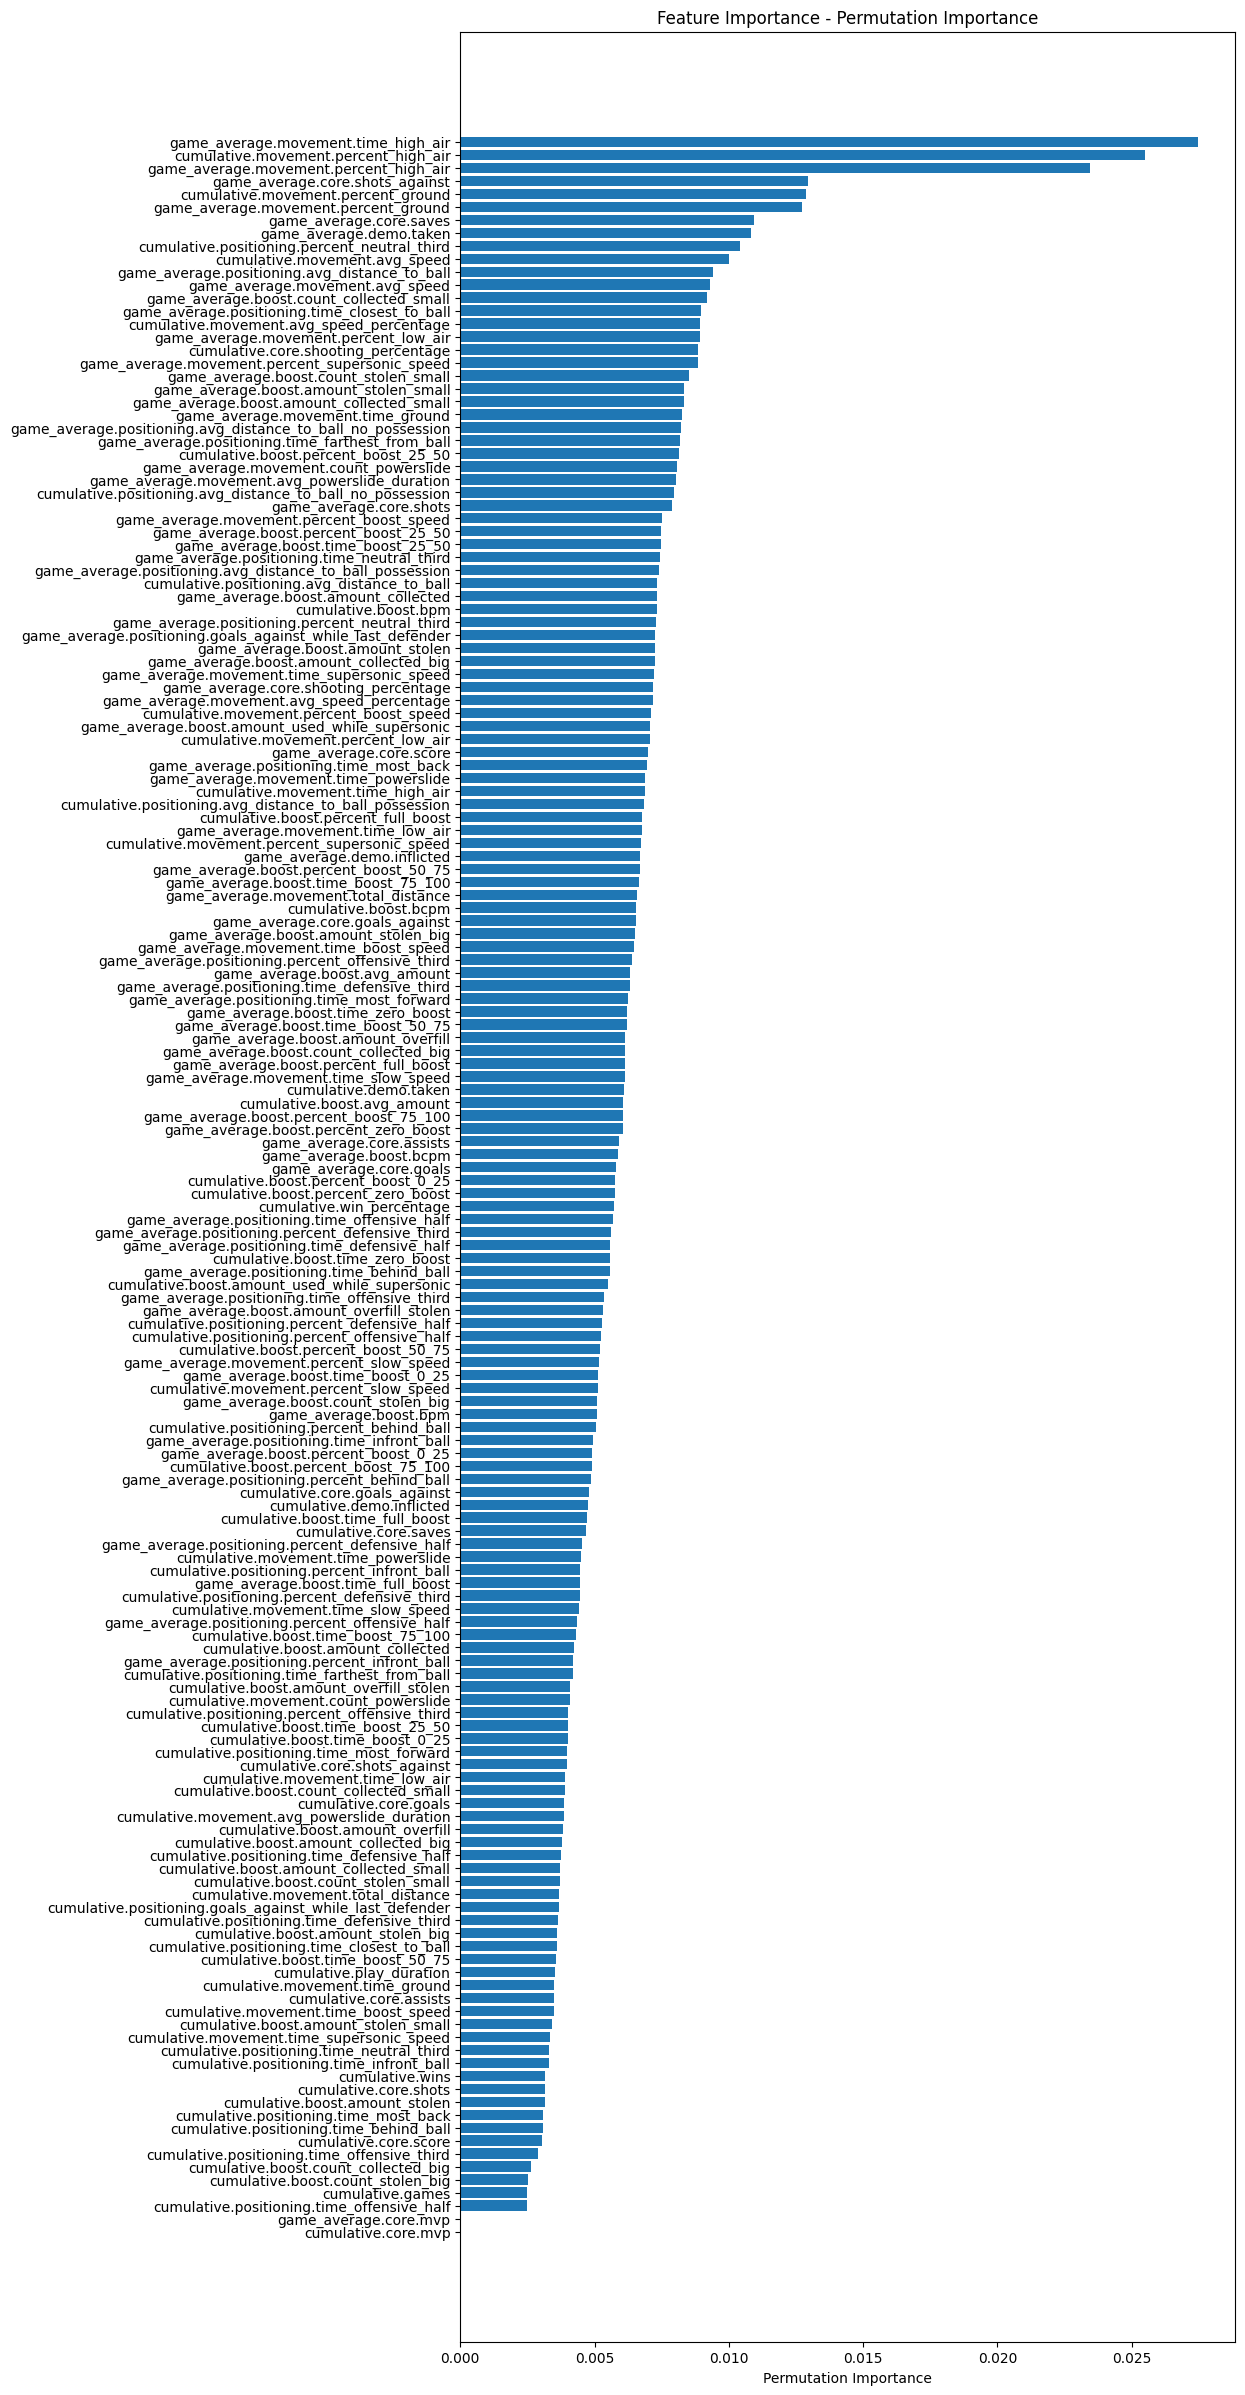

In [ ]:
# Extract feature importance scores
# Plot feature importance
feature_importance = best_rf_model.feature_importances_
feature_names = temp_player_df.drop(columns=['rank'], axis=1).columns  # Assuming you have column names for your features

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
sorted_feature_names = feature_names[sorted_idx]
print(list(sorted_feature_names))

# Plotting
plt.figure(figsize=(10, 30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance - Permutation Importance")
plt.show()

In [ ]:
test_url = "https://ballchasing.com/api/groups/12-2-tourney-groups-mker46age6/"
headers = {'Authorization': '8wjl1G9d8V8Ymfju7hH8K57aKNUiNhYe5oOYOxNr'}
response = requests.get(test_url, headers=headers)
data = json.loads(response.text)
temp_df = pd.json_normalize(data)

In [ ]:
for i in range(len(temp_df)):
  rank_df = pd.DataFrame(pd.json_normalize(temp_df.iloc[i]['players']))
  for j in range(len(rank_df)):
    temp_df = pd.DataFrame(rank_df.iloc[j]).T
    temp_df['rank'] = df.iloc[i]['rank']
    player_df = temp_df if i == 0 and j == 0 else pd.concat([player_df, temp_df])

display(player_df)

KeyError: ignored

In [ ]:
temp_player_df = player_df.drop(columns=['platform'], axis=1)
temp_player_df = temp_player_df.drop(columns=['id'], axis=1)
names = temp_player_df['name']
temp_player_df = temp_player_df.drop(columns=['name'], axis=1)
temp_player_df = temp_player_df.drop(columns=['team'], axis=1)

temp_player_df = temp_player_df.drop(columns=['cumulative.games'], axis=1)
# temp_player_df = temp_player_df.filter(like='percent')
# X = np.asarray(temp_player_df)
x = np.asarray(temp_player_df.drop(columns=['rank'], axis=1))

x_scaled = scaler.transform(x)

In [ ]:
predictions = model.predict(x_scaled, batch_size=None, verbose=1)

# print(predictions)

# Set the number of classes
num_classes = 9

# Calculate the number of rows and columns for the grid
num_samples = len(predictions)
num_rows = int(np.ceil(num_samples / 2))
num_cols = 2

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 16))

# Plot each sample's predictions
for i, pred in enumerate(predictions):
    row_idx = i // num_cols
    col_idx = i % num_cols

    ax = axes[row_idx, col_idx] if num_samples > 1 else axes

    ax.bar(range(num_classes), pred)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Probability')
    ax.set_title(f'{names[i]}')
    ax.set_xticks(range(num_classes))
    ax.set_xticklabels(classes, rotation=45, ha='right')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

InvalidArgumentError: ignored